## Optimization Project 1 - Image Segmentation
### Sarah Stephens (sgs2623), Tara Mary Joseph (tj9763), Theresa Sushil (ts42924), Sarah Lee (cl45274)

In [10]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import math
from PIL import Image
import os
from gurobipy import Model, GRB

In [2]:
### PARAMETERS TO TWEAK ###

# Similarity calculation parameter (sigma)
sigma = 0.3

# Define background and foreground pixel coordinates
background_row, background_col = 0, 0
foreground_row, foreground_col = 64,64

# Image file path (replace with your image path)
image_file = 'C:/Users/there/MSBA Resources/Optimization/Swan.jpg'

### END OF PARAMETERS ###

In the first step of the process, we define key paramenters to process into the algorithm. The sigma parameter controls the sensitivity to the pixel intensity or brightness, leading to the segmentation process. Additionally, the background and foreground pixel coordinates are specified, and the image file path is provided to set the foundation for processing the image.

In [3]:
# Check file extension to figure out how to load image
file_extension = os.path.splitext(image_file)[1].lower()

# Load image data
if file_extension == '.csv':
    # For CSV: load as matrix of pixel values
    image_data = np.loadtxt(image_file, delimiter=',')
elif file_extension in ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']:
    # For image files: load, convert to grayscale & resize
    image = Image.open(image_file).convert('L')
    print(image.width)
    # if image.height > 100 and image.width >100: #For images > 100*100, the image is being resized 
    #     image = image.resize((100, 100))
    image_data = np.array(image, dtype=np.float64)
else:
    raise ValueError('Error: Only CSV or image files are supported.')

# Get image size
image_height, image_width = image_data.shape

# Total number of pixels
num_pixels = image_height * image_width

128


With this setup information, the program loads the image depending on the file extension type, returning the image's height and width to determine the total number of pixels. Through this step, any type of image format is properly prepared for the segmentation algorithm. 

In [4]:
# Dictionary to hold similarities between neighboring pixels
similarity_graph = {}

# Variable to track the highest similarity value
max_sim_value = 0

# Iterate through each pixel in the image
for r in range(image_height):
    for c in range(image_width):
        # Flatten to 1D index
        pixel_idx = r * image_width + c
        # Get intensity of the current pixel
        pixel_intensity = image_data[r, c]

        # Define 4-nearest neighbors
        adjacent_directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

        # Loop through each direction to find neighboring pixels
        for dr, dc in adjacent_directions:
            nr, nc = r + dr, c + dc

            # Ensure neighbor is within image bounds
            if 0 <= nr < image_height and 0 <= nc < image_width:
                neighbor_idx = nr * image_width + nc
                neighbor_intensity = image_data[nr, nc]

                # Calculate similarity between current pixel & neighbor
                sim_value = np.ceil(100 * np.exp(-((pixel_intensity - neighbor_intensity) ** 2) / (2 * sigma ** 2)))

                # Save similarity to dictionary
                similarity_graph[(pixel_idx, neighbor_idx)] = sim_value

                # Update max similarity
                if sim_value > max_sim_value:
                    max_sim_value = sim_value

Next, a similarity graph is constructed in the form of a dictionary. Within this dictionary, the key is a pair of pixel (current and neighbor pixel) with its value of similarity or 'intensity'. Similarity is calculated by finding the difference of brightness or intensity between two pixels, with higher similarity values indicating closer intensity. During this calculation, each encounter is considered to update the highest similarity or max_sim_value. Essentially, this process assigns each pixels to the correspoding or similar neighbors based on its similarity calculation, preparing for the segmentation process.

In [5]:
# Compute the indices for background and foreground pixels
background_pixel = background_row * image_width + background_col
foreground_pixel = foreground_row * image_width + foreground_col

# Add source node and sink node connections
source_index = num_pixels
sink_index = num_pixels + 1

# Connect source to the background pixel with the max similarity
similarity_graph[(source_index, background_pixel)] = max_sim_value

# Connect sink to the foreground pixel with the max similarity
similarity_graph[(foreground_pixel, sink_index)] = max_sim_value

Source and sink nodes are established to connect with the background and foreground pixels, respectively. Based on the maximum similarity values from the previous step, this connection ensures proper assignement of pixels firmly to the background or foreground. 

In [6]:
# Initialize Gurobi model to calculate max flow
gurobi_model = Model('MaxFlow')

# Define decision variables for the flow on each edge in the graph
flow_values = {}
for (start, end), capacity in similarity_graph.items():
    flow_values[start, end] = gurobi_model.addVar(lb=0, ub=capacity, vtype=GRB.CONTINUOUS, name=f"flow_{start}_{end}")

# Objective = maximize flow from source to sink
nodes_in_graph = set(range(num_pixels)) | {source_index, sink_index}
flow_from_source = sum(flow_values[source_index, neighbor] for neighbor in nodes_in_graph if (source_index, neighbor) in flow_values)
gurobi_model.setObjective(flow_from_source, GRB.MAXIMIZE)

# Apply flow conservation for every node except source and sink
for node in nodes_in_graph:
    if node != source_index and node != sink_index:
        inflow = sum(flow_values[parent, node] for parent in nodes_in_graph if (parent, node) in flow_values)
        outflow = sum(flow_values[node, child] for child in nodes_in_graph if (node, child) in flow_values)
        gurobi_model.addConstr(inflow == outflow, name=f'flow_balance_{node}')

# Optimize!!!
gurobi_model.Params.OutputFlag = 0  # No output
gurobi_model.optimize()

# Print max flow value if optimal solution found
if gurobi_model.status == GRB.OPTIMAL:
    print(f"Max Flow: {gurobi_model.objVal}")

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-26
Max Flow: 13.0


Next, the max flow is computed from the source node to the sink node. A dictionary, flow_values, is created to keep all flow for each edge of two pixels. For each of these nodes/pixels, constraint is applied to ensure the entering flow (inflow) equates the leaving flow (outflow), maintaining flow conservation. After gurobi's optimization, the max flow is calculated, representing the strength of connection between the background (source) and the foreground (sink). 

In [7]:
# Build residual network (subtract flow from capacities)
residual_graph = {}
flow_results = gurobi_model.getAttr('X', flow_values)

for (i, j), capacity in similarity_graph.items():
    current_flow = flow_results[(i, j)]
    residual_capacity = capacity - current_flow
    if residual_capacity > 1e-4:
        residual_graph[(i, j)] = residual_capacity

The residual network is a modified dictionary of the original similarity graph dictionary, containing the difference of the capacity and its current flow. This difference, residual_capacity, indicates how much capacity was unused for that edge during the max flow optimization. Basically, the residual network consists of all edges that have remaining capcity after the max flow calculation. 

In [8]:
# DFS function to find reachable nodes in the residual graph
def depth_first_search(residual_graph, start_node):
    visited = [False] * (num_pixels + 2)
    stack = [start_node]
    reachable = set()
    
    while stack:
        node = stack.pop()
        if not visited[node]:
            visited[node] = True
            reachable.add(node)

            for neighbor in range(num_pixels + 2):
                if (node, neighbor) in residual_graph and residual_graph[(node, neighbor)] > 0 and not visited[neighbor]:
                    stack.append(neighbor)

    return reachable

# Run DFS from source node
reachable_nodes = depth_first_search(residual_graph, source_index)

# Identify nodes that can't be reached from the source
unreachable_nodes = set(range(num_pixels + 2)) - reachable_nodes

# Find cut edges
cut_edges = [(i, j) for (i, j) in similarity_graph.keys() if i in reachable_nodes and j in unreachable_nodes]
print(cut_edges)

[(6086, 6214), (6092, 6220), (6093, 6221), (6094, 6222), (6095, 6223), (6213, 6214), (6215, 6214), (6216, 6344), (6217, 6345), (6218, 6346), (6219, 6347), (6219, 6220), (6224, 6352), (6224, 6223), (6225, 6353), (6342, 6214), (6343, 6471), (6343, 6344), (6354, 6482), (6354, 6353), (6470, 6598), (6470, 6471), (6483, 6611), (6483, 6482), (6484, 6612), (6597, 6598), (6613, 6612), (6724, 6852), (6725, 6853), (6725, 6726), (6741, 6869), (6741, 6740), (6851, 6852), (6870, 6998), (6870, 6869), (6979, 6980), (6999, 7127), (6999, 6998), (7107, 7108), (7128, 7256), (7128, 7127), (7235, 7236), (7257, 7385), (7257, 7256), (7258, 7386), (7363, 7364), (7387, 7386), (7485, 7613), (7486, 7614), (7487, 7615), (7488, 7616), (7489, 7617), (7490, 7618), (7491, 7619), (7491, 7492), (7515, 7643), (7515, 7514), (7517, 7645), (7610, 7738), (7611, 7739), (7612, 7740), (7612, 7613), (7644, 7772), (7644, 7643), (7644, 7645), (7646, 7645), (7647, 7775), (7737, 7738), (7774, 7902), (7774, 7773), (7774, 7775), (7776

The depth first search (dfs) function establishes two nodes: reachable_nodes and unreachable_nodes. Starting from the source node, the function returns a stack of nodes reached from the source in the residual graph. On the other hand, the stack of nodes that can't be reached from the source in the residual graph is returned as unreachable_nodes as they are separated from the background/source. Additionally, the cut edges are defined, which solves the min cut part of the problem. Cut edges represent the edges that connect a reachable node from the background to a unreachable node from the foreground, defining pixel regions to separate the object of interest (foreground) from its background. 

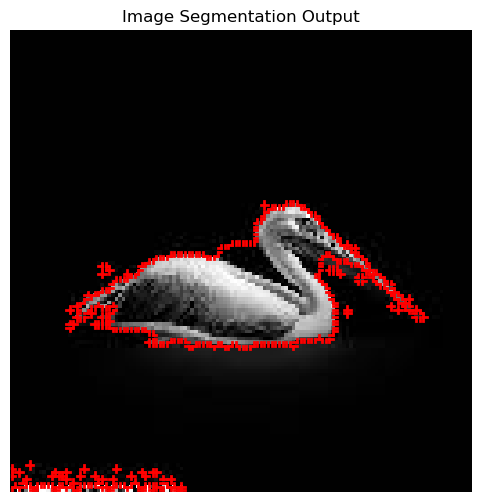

In [9]:
# Prep pixel data
pixel_array = image_data

# Plot og image & overlay cuts
plt.figure(figsize=(6, 6))
plt.imshow(pixel_array, cmap='gray', origin='upper')
plt.axis('off')

for (i, j) in cut_edges:
    row_i, col_i = divmod(i, image_width)
    row_j, col_j = divmod(j, image_width)
    plt.plot([col_i, col_j], [row_i, row_j], color='red', linewidth=2)

plt.title('Image Segmentation Output')
plt.show()

Finally, the original image is displayed with the red cut edges. The red lines represent the boundaries between the foreground and background or the segmentation results calculated by the algorithm. Above all, the final output visually assesses the similarity computation and the max flow min cut algorithm with the provided parameters. 

Credit to ChatGPT for help with general organization of ideas, niche code blocks, and debugging